In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! ls 'drive/My Drive/프로젝트/kt_intern'

data_clustering.ipynb  preprocessed_data.csv  wine_data_onehotencoding.csv
model_211230.pth       target.csv	      wine_DNN_du.ipynb
others		       Untitled0.ipynb	      wine_DNN.ipynb


In [3]:
import torch
import gc

torch.cuda.empty_cache()
gc.collect()

11

In [2]:
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import shutil
import random
from sklearn.metrics import classification_report
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import torch.optim as optim
import torch.utils.data as utils
import torch.utils.data as td
import tqdm 

In [3]:
data_path = 'drive/My Drive/프로젝트/kt_intern/preprocessed_data.csv'
target_path = 'drive/My Drive/프로젝트/kt_intern/target.csv'

X_data = pd.read_csv(data_path, encoding='cp949')
X_data.drop(['Unnamed: 0'], axis = 1, inplace = True)
X_data

,품종_가르가네가 (Garganega),품종_가르나차 (Garnacha),품종_가르나차 (Garnatxa),품종_가르나차 틴토레라 (Garnacha Tintorera),품종_가메이 (Gamay),품종_게뷔르츠트라미너 (Gewurztraminer),품종_고데요 (Godello),품종_그레케토 비앙코 (Grechetto Bianco),품종_그레코 비앙코 (Greco Bianco),품종_그로 만생 (Gros Manseng),품종_그뤼너 벨트리너 (Gruner Veltliner),품종_그르나슈 (Grenache),품종_그르나슈 블랑 (Grenache Blanc),품종_그릴로 (Grillo),품종_글레라 (Glera),품종_까넬리 모스카토 (Canelli Moscato),품종_까리냥 (Carignan/Carignane),품종_까리네나 (Carinena),품종_나스세따 (Nascetta),품종_네그로아마로 (Negroamaro),품종_네렐로 마스칼레제 (Nerello Mascalese),품종_네로 다볼라 (Nero d'Avola),품종_네로 디 트로이아 (Nero di Troia),품종_네비올로 (Nebbiolo),품종_돈펠더 (Dornfelder),품종_돌체토 (Dolcetto),품종_따나 (Tannat),품종_라그레인 (Lagrein),품종_라보소 (Raboso),품종_라크리마 (Lacrima),품종_람브루스코 (Lambrusco),품종_레불라 (Rebula),품종_레포스코 (Refosco),품종_로트기플러 (Rotgipfler),품종_루산느 (Roussanne),품종_리바너 (Rivaner),품종_리볼라 지알라 (Ribolla Gialla),품종_리슬링 (Riesling),품종_리켓사이텔리 (Rkatsiteli),품종_마르산느 (Marsanne),...,품종_프로세코 (Prosecco),품종_프루놀로 젠타일 (Prugnolo Gentile),품종_프리미티보 (Primitivo),품종_프리울라노 (Friulano),품종_플라바치 말리 (Plavac Mali),품종_피노 그리 (Pinot Gris),품종_피노 그리지오 (Pinot Grigio),품종_피노 네로 (Pinot Nero),품종_피노 누아 (Pinot Noir),품종_피노 뮈니에 (Pinot Meunier),품종_피노 블랑 (Pinot Blanc),품종_피노 비앙코 (Pinot Bianco),품종_피노타주 (Pinotage),품종_피뇰레또 (Pignoletto),품종_피아노 (Fiano),품종_훅셀레베 (Huxelrebe),당도_0,당도_1,당도_2,당도_3,당도_4,당도_5,산도_0,산도_1,산도_2,산도_3,산도_4,산도_5,바디_0,바디_1,바디_2,바디_3,바디_4,바디_5,타닌_0,타닌_1,타닌_2,타닌_3,타닌_4,타닌_5
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11643,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0
11644,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0
11645,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0
11646,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0


In [4]:
## target data
y_data = pd.read_csv(target_path)
y_data

,0
0,3
1,3
2,5
3,2
4,2
...,...
11643,0
11644,0
11645,7
11646,0


In [5]:
X_data_1 = X_data.to_numpy()
y_data_1 = y_data.to_numpy()

In [6]:
## y_data into one-hot-encoding
y_data_2=pd.DataFrame(y_data_1)
y_data_2=pd.get_dummies(y_data_2[0])
y_data_2

,0,1,2,3,4,5,6,7
0,0,0,0,1,0,0,0,0
1,0,0,0,1,0,0,0,0
2,0,0,0,0,0,1,0,0
3,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...
11643,1,0,0,0,0,0,0,0
11644,1,0,0,0,0,0,0,0
11645,0,0,0,0,0,0,0,1
11646,1,0,0,0,0,0,0,0


In [7]:
y_data_2 = y_data_2.to_numpy()
y_data_2

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]], dtype=uint8)

In [8]:
## Split the data set into training, validation and testing
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X_data_1, y_data_2, test_size=0.2, random_state=2021)
X_test_data, X_val_data, y_test_data, y_val_data = train_test_split(X_test_data, y_test_data, test_size=0.5, random_state=2021)

In [9]:
display(X_train_data.shape)
display(X_test_data.shape)
display(X_val_data.shape)
display(y_train_data.shape)
display(y_test_data.shape)
display(y_val_data.shape)

(9318, 199)

(1165, 199)

(1165, 199)

(9318, 8)

(1165, 8)

(1165, 8)

In [10]:
EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 0.001

INPUT_DIM = len(X_train_data[0]) # feature 개수
OUTPUT_CLASS = len(y_train_data[0]) # class 개수

# wine_cluster_id = {'Electronic':0, 'Country':1, 'R&B':2, 'Jazz':3, 'Indie':4, 'Pop':5, 'Folk':6, 'Metal':7}

In [11]:
# Create DataLoaders

# Create a dataset and loader for the training data and labels
train_x = torch.Tensor(X_train_data).float()
train_y = torch.Tensor(y_train_data)
train_ds = utils.TensorDataset(train_x,train_y)
train_loader = td.DataLoader(train_ds, batch_size=BATCH_SIZE,shuffle=True, num_workers=1)

# Create a dataset and loader for the test data and labels
test_x = torch.Tensor(X_test_data).float()
test_y = torch.Tensor(y_test_data)
test_ds = utils.TensorDataset(test_x,test_y)
test_loader = td.DataLoader(test_ds, batch_size=1, shuffle=True, num_workers=1)

# Create a dataset and loader for the test data and labels
val_x = torch.Tensor(X_val_data).float()
val_y = torch.Tensor(y_val_data)
val_ds = utils.TensorDataset(val_x,val_y)
val_loader = td.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)

print("Loaders ready")

Loaders ready


In [12]:
# DNN model
class Model(nn.Module):
    def __init__(self, input_dim, output_class):
        super(Model, self).__init__()
        # input_dim : input features의 개수
        # output_class : output class의 개수
        ## batchnorm은 Relu 넣고 그 사이에 넣을 것.
        self.layer_1 = nn.Linear(input_dim, 200)
        self.layer_2 = nn.Linear(200, 100)
        self.layer_3 = nn.Linear(100, 200)
        self.layer_4 = nn.Linear(200, 50)
        self.layer_out = nn.Linear(50, output_class)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm_1 = nn.BatchNorm1d(200)
        self.batchnorm_2 = nn.BatchNorm1d(100)
        self.batchnorm_3 = nn.BatchNorm1d(200)
        self.batchnorm_4 = nn.BatchNorm1d(50)
        self.softmax = nn.Softmax()
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm_1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm_2(x)
        x = self.relu(self.layer_3(x))
        x = self.batchnorm_3(x)
        x = self.relu(self.layer_4(x))
        x = self.batchnorm_4(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        x = self.softmax(x)
        return x

In [13]:
# GPU 할당
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Running on device: {device}')

Running on device: cpu


In [14]:
# 모델 선언
model = Model(INPUT_DIM,OUTPUT_CLASS)
model.to(device)
print(model)

# loss function, optimizer 선언
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

Model(
  (layer_1): Linear(in_features=199, out_features=200, bias=True)
  (layer_2): Linear(in_features=200, out_features=100, bias=True)
  (layer_3): Linear(in_features=100, out_features=200, bias=True)
  (layer_4): Linear(in_features=200, out_features=50, bias=True)
  (layer_out): Linear(in_features=50, out_features=8, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm_1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_3): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (softmax): Softmax(dim=None)
)


In [15]:
#Train the model - track metrics for each epoch in these arrays
epoch_nums = []
training_loss = []
validation_loss = []
training_acc = []
validation_acc = []


# Train over set epochs

for epoch in range(1, EPOCHS + 1):
    
    # Feed the training data into the model to optimize the weights
    # train_loss,valid_loss = train(model, train_loader,val_loader, criterion, optimizer)
    model.train()
    train_loss = 0
    valid_loss = 0
    train_acc = 0
    valid_acc = 0
    
    for X_train_batch, y_train_batch in  train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)

        #forward
        optimizer.zero_grad()
        pred = model(X_train_batch)

        # feature 단위로 loss 값 계산
        loss = criterion(pred, y_train_batch)
        
        ## acc 계산
        # decode한 값 : y_train_pred & y_train_decode
        y_train_pred = np.argmax(pred.detach().cpu().numpy(),axis=1).flatten()
        y_train_pred = y_train_pred.reshape((-1,1))

        y_train_decode = np.argmax(y_train_batch.detach().cpu().numpy(),axis=1).flatten()
        y_train_decode = y_train_decode.reshape((-1,1))

        acc = np.mean(y_train_pred == y_train_decode)

        train_loss += loss.item()
        train_acc += acc

        # backpropagate
        loss.backward()
        optimizer.step()

    ## evaluation part 
    model.eval()
    for X_val_batch, y_val_batch in  val_loader:
        X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

        pred = model(X_val_batch)
        # feature 단위로 loss 값 계산
        loss = criterion(pred, y_val_batch)

        ## acc 계산
        y_val_pred = np.argmax(pred.detach().cpu().numpy(),axis=1).flatten()
        y_val_pred = y_val_pred.reshape((-1,1))

        y_val_decode = np.argmax(y_val_batch.detach().cpu().numpy(),axis=1).flatten()
        y_val_decode = y_val_decode.reshape((-1,1))
        
        acc = np.mean(y_val_pred == y_val_decode)

        valid_loss += loss.item()
        valid_acc += acc
              
    # Return loss
    avg_loss_train = train_loss / len(train_loader)
    avg_loss_val = valid_loss / len(val_loader)
    avg_acc_train = train_acc / len(train_loader)
    avg_acc_val = valid_acc / len(val_loader)
    
    # Log the metrcs for this epoch
    epoch_nums.append(epoch)
    training_loss.append(avg_loss_train)
    validation_loss.append(avg_loss_val)
    training_acc.append(avg_acc_train)
    validation_acc.append(avg_acc_val)

    
    # Print stats for every 10th epoch so we can see training progress
    if (epoch) % 1 == 0:
        print('Epoch {:d}: Training loss= {:.4f}, Training acc= {:.4f}, Validation loss= {:.4f}, Validation acc= {:.4f}'.format(epoch, avg_loss_train, avg_acc_train, avg_loss_val, avg_acc_val))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1: Training loss= 1.3441, Training acc= 0.9692, Validation loss= 1.2827, Validation acc= 0.9958
Epoch 2: Training loss= 1.2870, Training acc= 0.9910, Validation loss= 1.2801, Validation acc= 0.9949
Epoch 3: Training loss= 1.2871, Training acc= 0.9885, Validation loss= 1.2782, Validation acc= 0.9958
Epoch 4: Training loss= 1.2824, Training acc= 0.9936, Validation loss= 1.2778, Validation acc= 0.9975
Epoch 5: Training loss= 1.2814, Training acc= 0.9932, Validation loss= 1.2792, Validation acc= 0.9949
Epoch 6: Training loss= 1.2811, Training acc= 0.9935, Validation loss= 1.2779, Validation acc= 0.9958
Epoch 7: Training loss= 1.2797, Training acc= 0.9949, Validation loss= 1.2790, Validation acc= 0.9949
Epoch 8: Training loss= 1.2790, Training acc= 0.9956, Validation loss= 1.2779, Validation acc= 0.9958
Epoch 9: Training loss= 1.2795, Training acc= 0.9952, Validation loss= 1.2805, Validation acc= 0.9924
Epoch 10: Training loss= 1.2808, Training acc= 0.9937, Validation loss= 1.2780, Va

In [16]:
# 모델 선언
print(model)

Model(
  (layer_1): Linear(in_features=199, out_features=200, bias=True)
  (layer_2): Linear(in_features=200, out_features=100, bias=True)
  (layer_3): Linear(in_features=100, out_features=200, bias=True)
  (layer_4): Linear(in_features=200, out_features=50, bias=True)
  (layer_out): Linear(in_features=50, out_features=8, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm_1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_3): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (softmax): Softmax(dim=None)
)


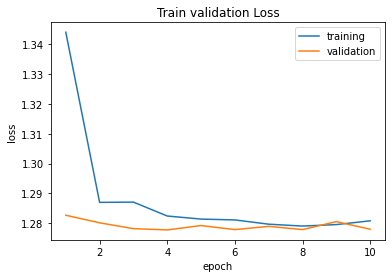

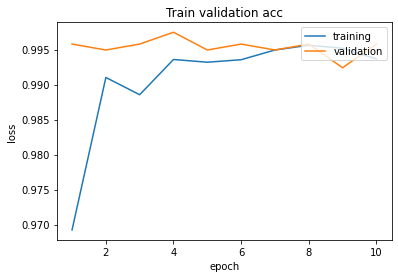

In [17]:
from matplotlib import pyplot as plt #python package to draw graphs in python

plt.title('Train validation Loss')
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

plt.title('Train validation acc')
plt.plot(epoch_nums, training_acc)
plt.plot(epoch_nums, validation_acc)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()


In [63]:
# Learned Weights and Biases
# for param_tensor in model.state_dict():
#     print(param_tensor, "\n", model.state_dict()[param_tensor].numpy())

In [18]:
## test

model.eval()

real_labels = []
prediction_labels = []

test_acc = 0
count = 0

with torch.no_grad():
  for X_test_batch, y_test_batch in  test_loader:
    count += 1
    X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)

    pred = model(X_test_batch)

    ## acc 계산
    y_test_pred = np.argmax(pred.detach().cpu().numpy(),axis=1).flatten()
    prediction_labels += y_test_pred.tolist()

    y_test_decode = np.argmax(y_test_batch.detach().cpu().numpy(),axis=1).flatten()
    real_labels += y_test_decode.tolist()
        
    acc = np.mean(y_test_pred == y_test_decode)
    test_acc += acc

    if count % 100 == 0:
      avg_accuracy = test_acc / len(test_loader.dataset)
      print('Test data {:d}: acc= {:.4f}'.format(count, avg_accuracy))

  avg_accuracy = test_acc / len(test_loader.dataset)
  print('Final Test Accuracy= {:.4f}'.format(avg_accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Test data 100: acc= 0.0850
Test data 200: acc= 0.1708
Test data 300: acc= 0.2567
Test data 400: acc= 0.3416
Test data 500: acc= 0.4275
Test data 600: acc= 0.5133
Test data 700: acc= 0.5991
Test data 800: acc= 0.6850
Test data 900: acc= 0.7708
Test data 1000: acc= 0.8567
Test data 1100: acc= 0.9399
Final Test Accuracy= 0.9957


In [19]:
# 모델 선언
print(model)


Model(
  (layer_1): Linear(in_features=199, out_features=200, bias=True)
  (layer_2): Linear(in_features=200, out_features=100, bias=True)
  (layer_3): Linear(in_features=100, out_features=200, bias=True)
  (layer_4): Linear(in_features=200, out_features=50, bias=True)
  (layer_out): Linear(in_features=50, out_features=8, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm_1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_3): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (softmax): Softmax(dim=None)
)


In [20]:
## check
print(real_labels)
print(prediction_labels)

[4, 6, 7, 4, 6, 4, 1, 6, 2, 5, 3, 7, 4, 2, 0, 4, 6, 7, 4, 6, 0, 0, 4, 1, 5, 4, 4, 7, 0, 0, 3, 7, 1, 4, 2, 1, 7, 0, 1, 5, 0, 1, 7, 2, 0, 4, 7, 5, 0, 5, 0, 4, 4, 7, 6, 0, 0, 0, 5, 2, 0, 1, 3, 3, 0, 6, 7, 1, 4, 1, 5, 0, 1, 2, 0, 5, 2, 1, 3, 7, 5, 5, 4, 2, 5, 3, 7, 1, 7, 0, 5, 0, 1, 5, 5, 6, 5, 7, 6, 7, 5, 2, 1, 4, 0, 6, 4, 6, 2, 3, 4, 4, 7, 4, 0, 7, 5, 3, 5, 4, 7, 4, 2, 0, 4, 2, 0, 1, 3, 7, 1, 1, 2, 0, 4, 6, 4, 7, 2, 4, 7, 1, 5, 7, 4, 5, 1, 2, 7, 2, 5, 5, 5, 0, 0, 7, 3, 0, 1, 7, 1, 4, 0, 4, 3, 7, 5, 7, 1, 2, 4, 1, 2, 4, 5, 1, 5, 7, 6, 0, 3, 4, 7, 1, 4, 4, 4, 5, 3, 0, 0, 4, 4, 1, 0, 4, 4, 1, 2, 3, 1, 5, 6, 1, 1, 5, 1, 5, 4, 3, 0, 6, 1, 3, 7, 1, 1, 5, 5, 6, 1, 3, 0, 6, 4, 5, 0, 5, 0, 5, 0, 6, 0, 1, 7, 5, 5, 0, 2, 3, 3, 0, 4, 4, 7, 3, 4, 1, 1, 5, 5, 7, 5, 6, 2, 5, 1, 7, 1, 3, 2, 3, 3, 2, 2, 2, 4, 5, 6, 7, 5, 2, 1, 7, 5, 7, 1, 7, 5, 1, 3, 7, 3, 3, 0, 7, 3, 4, 5, 7, 5, 5, 7, 7, 5, 6, 7, 1, 5, 0, 4, 3, 4, 7, 5, 7, 4, 0, 7, 1, 0, 7, 4, 3, 6, 0, 4, 6, 0, 1, 4, 3, 0, 6, 1, 2, 3, 0, 2, 6, 5, 5, 2, 

In [21]:
# evaluation_report = classification_report(real_labels, prediction_labels, labels=list(wine_cluster_id.values()), target_names=list(wine_cluster_id.keys()))
evaluation_report = classification_report(real_labels, prediction_labels)
print(evaluation_report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       184
           1       0.99      1.00      0.99       145
           2       1.00      1.00      1.00        91
           3       1.00      1.00      1.00       115
           4       1.00      1.00      1.00       173
           5       1.00      0.99      1.00       204
           6       0.99      0.98      0.98        97
           7       1.00      1.00      1.00       156

    accuracy                           1.00      1165
   macro avg       1.00      1.00      1.00      1165
weighted avg       1.00      1.00      1.00      1165



In [22]:
print(model)

Model(
  (layer_1): Linear(in_features=199, out_features=200, bias=True)
  (layer_2): Linear(in_features=200, out_features=100, bias=True)
  (layer_3): Linear(in_features=100, out_features=200, bias=True)
  (layer_4): Linear(in_features=200, out_features=50, bias=True)
  (layer_out): Linear(in_features=50, out_features=8, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm_1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_3): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (softmax): Softmax(dim=None)
)


In [26]:
## 모델 저장
torch.save(model, 'drive/My Drive/프로젝트/kt_intern/model_211230.pth')


In [25]:
## 모델 로드
the_model = torch.load('drive/My Drive/프로젝트/kt_intern/model_211230.pth')
the_model.eval()

Model(
  (layer_1): Linear(in_features=199, out_features=200, bias=True)
  (layer_2): Linear(in_features=200, out_features=100, bias=True)
  (layer_3): Linear(in_features=100, out_features=200, bias=True)
  (layer_4): Linear(in_features=200, out_features=50, bias=True)
  (layer_out): Linear(in_features=50, out_features=8, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm_1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_3): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (softmax): Softmax(dim=None)
)

In [ ]:
r'''
고양이 사진 >> 고양이
(모델)

사진 >> (모델) >> 고양이 / 고양이 판단



민아 >> 와인 a, b, c, d 6 2 3 1
  a >>   ((모델)) >> 6번 군집

  >> 6번 군집 >>> 와인 2개 추천 << 1000개 와인 // 2개를 뽑아줘야할까?
  호텔 와인 db : 30개 >> 8개 군집에 포진? >> 군집 : 2개

  >> db 측 : 1. 와인 평점 달아주세요 2. 군집레이블을 줄 건데, 포함 시켜주세요

  >> 6번 군집 << 4개 와인(가5 나3 다2 라1)
  + 조건 : 내가 넣은 와인을 제외하고.
  어떤 거 2개?
'''